## Imports

In [24]:
import json
import os
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter, defaultdict
from scipy.optimize import least_squares
from scipy.sparse import lil_matrix

## Helper Functions for Phase 1 ##

In [4]:
PROJECT_ROOT = Path(".").resolve()

def imshow_rgb(title, img_bgr, scale=0.35):
    rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
    h, w = rgb.shape[:2]
    plt.figure(figsize=(scale*w/100, scale*h/100))
    plt.title(title); plt.axis("off"); plt.imshow(rgb); plt.show()

def build_K_from_image(img):
    H, W = img.shape[:2]
    fx = fy = float(W) # this is what is stated in phase 1 of the project PDF
    cx, cy = W/2.0, H/2.0
    return np.array([[fx, 0.0, cx],
                     [0.0, fy, cy],
                     [0.0, 0.0, 1.0]], dtype=np.float64)

def write_ply(path, points):
    pts = np.asarray(points, dtype=np.float32)
    with open(path, "w") as f:
        f.write("ply\nformat ascii 1.0\n")
        f.write(f"element vertex {len(pts)}\n")
        f.write("property float x\nproperty float y\nproperty float z\n")
        f.write("end_header\n")
        for p in pts:
            f.write(f"{p[0]} {p[1]} {p[2]}\n")


## Feature Detection & Matching ##

In [5]:
def get_detector(name="SIFT"):
    name = name.upper()
    if name == "SIFT":
        return cv.SIFT_create(), cv.NORM_L2, 0.75
    if name == "ORB":
        return cv.ORB_create(nfeatures=3000), cv.NORM_HAMMING, 0.78
    raise ValueError("Use 'SIFT' or 'ORB'")

def detect_and_match(img1, img2, algo="SIFT", ratio=None):
    det, norm, default_ratio = get_detector(algo)
    if ratio is None:
        ratio = default_ratio

    g1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    g2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
    kp1, des1 = det.detectAndCompute(g1, None)
    kp2, des2 = det.detectAndCompute(g2, None)

    bf = cv.BFMatcher(norm, crossCheck=False)
    knn = bf.knnMatch(des1, des2, k=2)
    good = [m for m, n in knn if n is not None and m.distance < ratio * n.distance]

    pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good])

    return kp1, kp2, good, pts1, pts2

def draw_matches_inline(img1, kp1, img2, kp2, matches, title="matches", scale=0.35):
    vis = cv.drawMatches(img1, kp1, img2, kp2, matches, None,
                         flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    imshow_rgb(title, vis, scale=scale)


## Determining Essential Matrix, Triangulation and Cheirality Check ##

In [6]:
def find_E_ransac(pts1, pts2, K, threshold_px=2.0):
    E, mask = cv.findEssentialMat(pts1, pts2, K, method=cv.RANSAC,
                                  prob=0.999, threshold=threshold_px)
    if E is None or mask is None or np.count_nonzero(mask) < 5:
        raise RuntimeError("Essential RANSAC failed")
    keep = (mask.ravel() != 0)
    return E, pts1[keep], pts2[keep], keep

def decompose_E_four(E):
    # svd-based decomposition
    U, _, Vt = np.linalg.svd(E)
    if np.linalg.det(U) < 0: U[:, -1] *= -1
    if np.linalg.det(Vt) < 0: Vt[-1, :] *= -1
    W = np.array([[0, -1, 0],
                  [1,  0, 0],
                  [0,  0, 1]], dtype=np.float64)
    R1 = U @ W  @ Vt
    R2 = U @ W.T @ Vt
    t  = U[:, 2]
    
    if np.linalg.det(R1) < 0: R1 *= -1
    if np.linalg.det(R2) < 0: R2 *= -1
    poses = [(R1,  t.reshape(3,1)),
             (R1, -t.reshape(3,1)),
             (R2,  t.reshape(3,1)),
             (R2, -t.reshape(3,1))]
    return poses

def triangulate(K, R, t, pts1, pts2):
    P1 = K @ np.hstack([np.eye(3), np.zeros((3,1))])
    P2 = K @ np.hstack([R, t])
    Xh = cv.triangulatePoints(P1.astype(np.float64),
                              P2.astype(np.float64),
                              pts1.T.astype(np.float64),
                              pts2.T.astype(np.float64)) # 4xN matrix
    X = (Xh[:3] / Xh[3]).T # Nx3 matrix
    return X

def cheirality_score(R, t, K, pts1, pts2):
    X = triangulate(K, R, t, pts1, pts2)
    
    Z1 = X[:, 2]
    Z2 = (X @ R[2, :].T + t[2, 0])
    good = (Z1 > 0) & (Z2 > 0)
    return int(np.count_nonzero(good)), X, good

def select_pose_by_cheirality(E, K, inl1, inl2):
    best = None
    for i, (R, t) in enumerate(decompose_E_four(E)):
        count, X, mask = cheirality_score(R, t, K, inl1, inl2)
        if best is None or count > best[0]:
            best = (count, R, t, X, mask)
    return best

def reprojection_rmse(K, R, t, pts1, pts2, X):
    P1 = K @ np.hstack([np.eye(3), np.zeros((3,1))])
    P2 = K @ np.hstack([R, t])
    Xh = np.hstack([X, np.ones((len(X),1))]).T
    p1 = (P1 @ Xh); p1 /= p1[2]; p1 = p1[:2].T
    p2 = (P2 @ Xh); p2 /= p2[2]; p2 = p2[:2].T
    e1 = np.linalg.norm(p1 - pts1, axis=1)
    e2 = np.linalg.norm(p2 - pts2, axis=1)
    return float(np.sqrt(np.mean(e1**2))), float(np.sqrt(np.mean(e2**2)))


## Grid Like Display of recorded Dataset ##

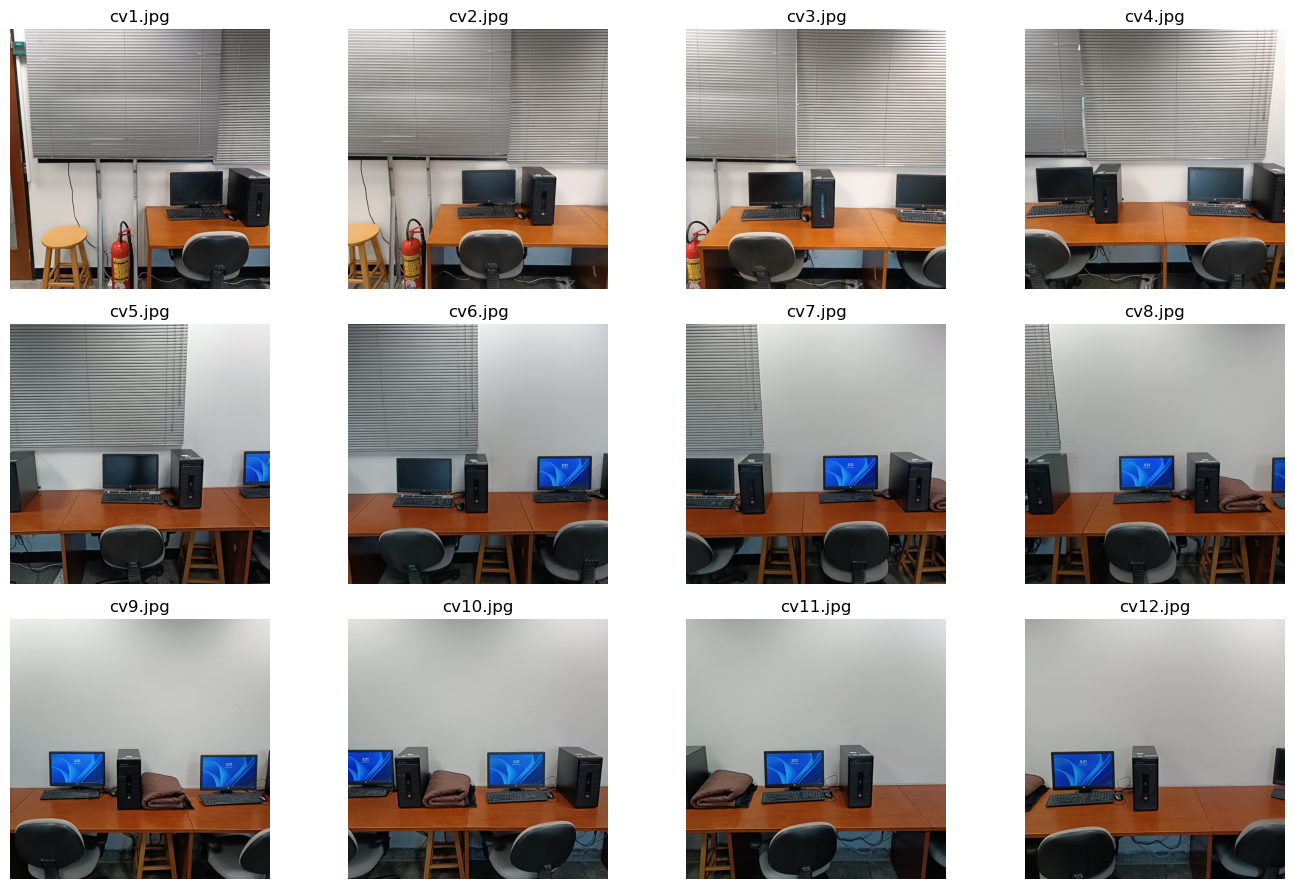

In [7]:
# displaying my 12 images
folder = "Images/Test"
paths  = [f"{folder}/cv{i}.jpg" for i in range(1, 13)]
imgs   = [cv.imread(p, cv.IMREAD_COLOR) for p in paths]
assert all(im is not None for im in imgs), "One or more images not found."

# downscaling for faster plotting as this grid is just for display purposes
def disp_resize(im, max_w=1200):
    if im.shape[1] <= max_w: return im
    s = max_w / im.shape[1]
    return cv.resize(im, (max_w, int(im.shape[0]*s)), interpolation=cv.INTER_AREA)

plt.figure(figsize=(14, 9))
for i, im in enumerate(imgs, 1):
    plt.subplot(3, 4, i)
    rgb = cv.cvtColor(disp_resize(im), cv.COLOR_BGR2RGB)
    plt.imshow(rgb); plt.title(f"cv{i}.jpg"); plt.axis("off")
plt.tight_layout(); plt.show()


## Phase 1 Function Calling ##

K-matrix:
 [[3000.    0. 1500.]
 [   0. 3000. 1500.]
 [   0.    0.    1.]]
SIFT: ratio-kept = 1592


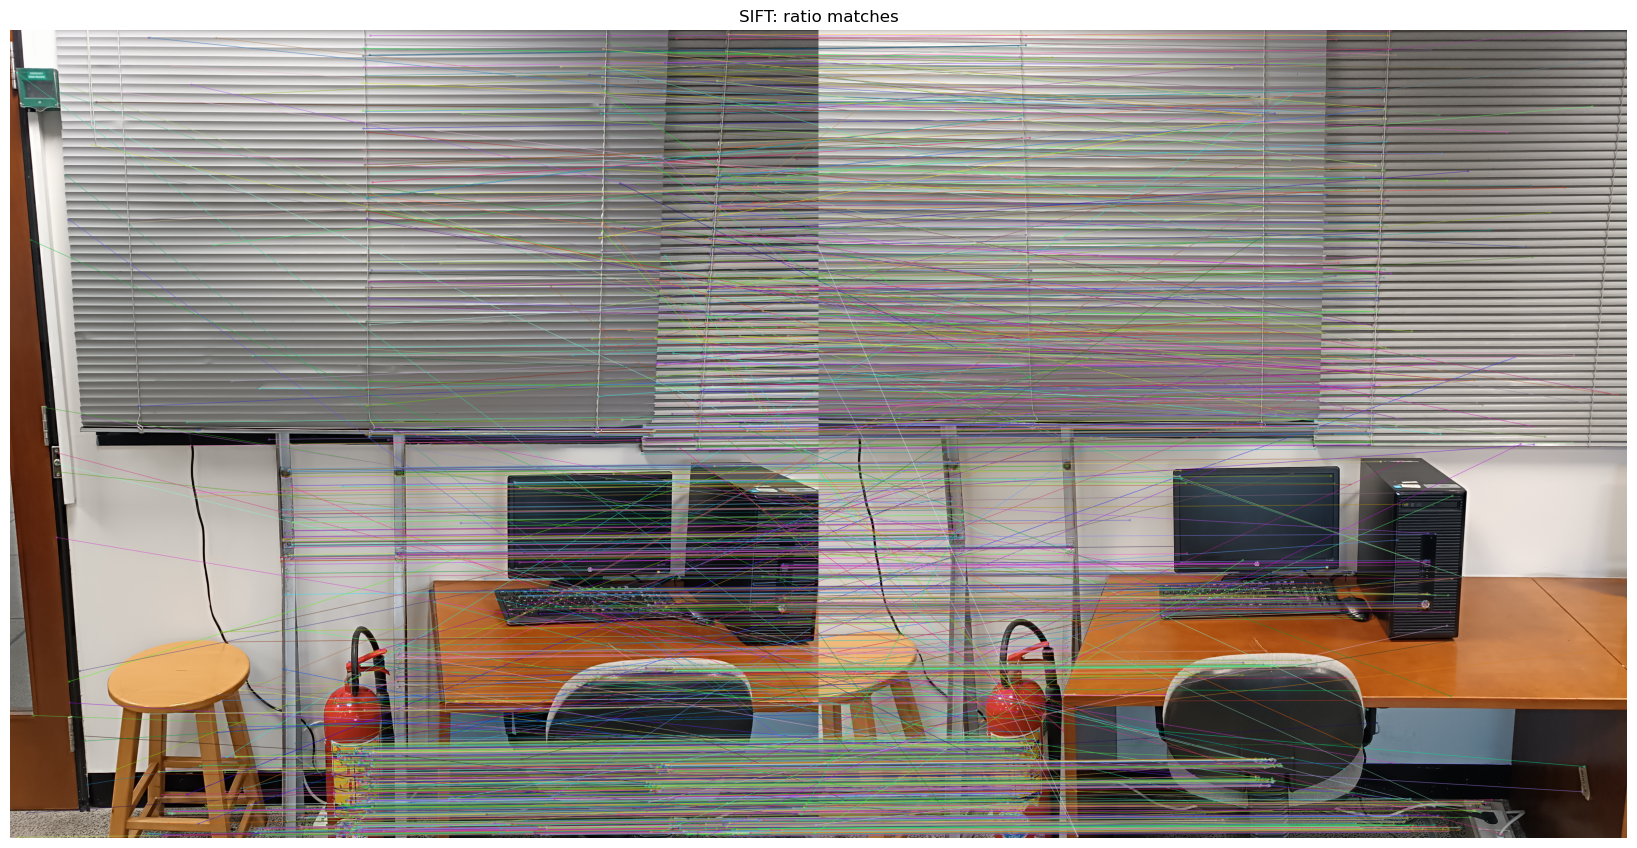

E-RANSAC inliers = 1045
Estimated essential matrix E (shape (3, 3)):
[[-0.     -0.0037  0.002 ]
 [ 0.0068 -0.0055 -0.707 ]
 [ 0.0028  0.7071 -0.0055]]

Cheirality best (points in front of both cams) = 1045
Selected pose (SVD route):
R_svd =
 [[ 1.     -0.0067  0.0044]
 [ 0.0067  0.9999 -0.0077]
 [-0.0043  0.0078  1.    ]]
t_svd^T = [-1.     -0.0028 -0.0053]

OpenCV recoverPose result:
R_cv =
 [[ 1.     -0.0067  0.0044]
 [ 0.0067  0.9999 -0.0077]
 [-0.0043  0.0078  1.    ]]
t_cv^T = [-1.     -0.0028 -0.0053]
Points in front of both cameras (recoverPose): 1044
Inlier count used by recoverPose mask: 266220

Pose agreement comparison:
‣ ||R_svd - R_cv||_F = 1.4124e-15
‣ angle(t_svd, t_cv) up to sign = 0.000 deg

Reproj RMSE (px): view1=0.49, view2=0.49


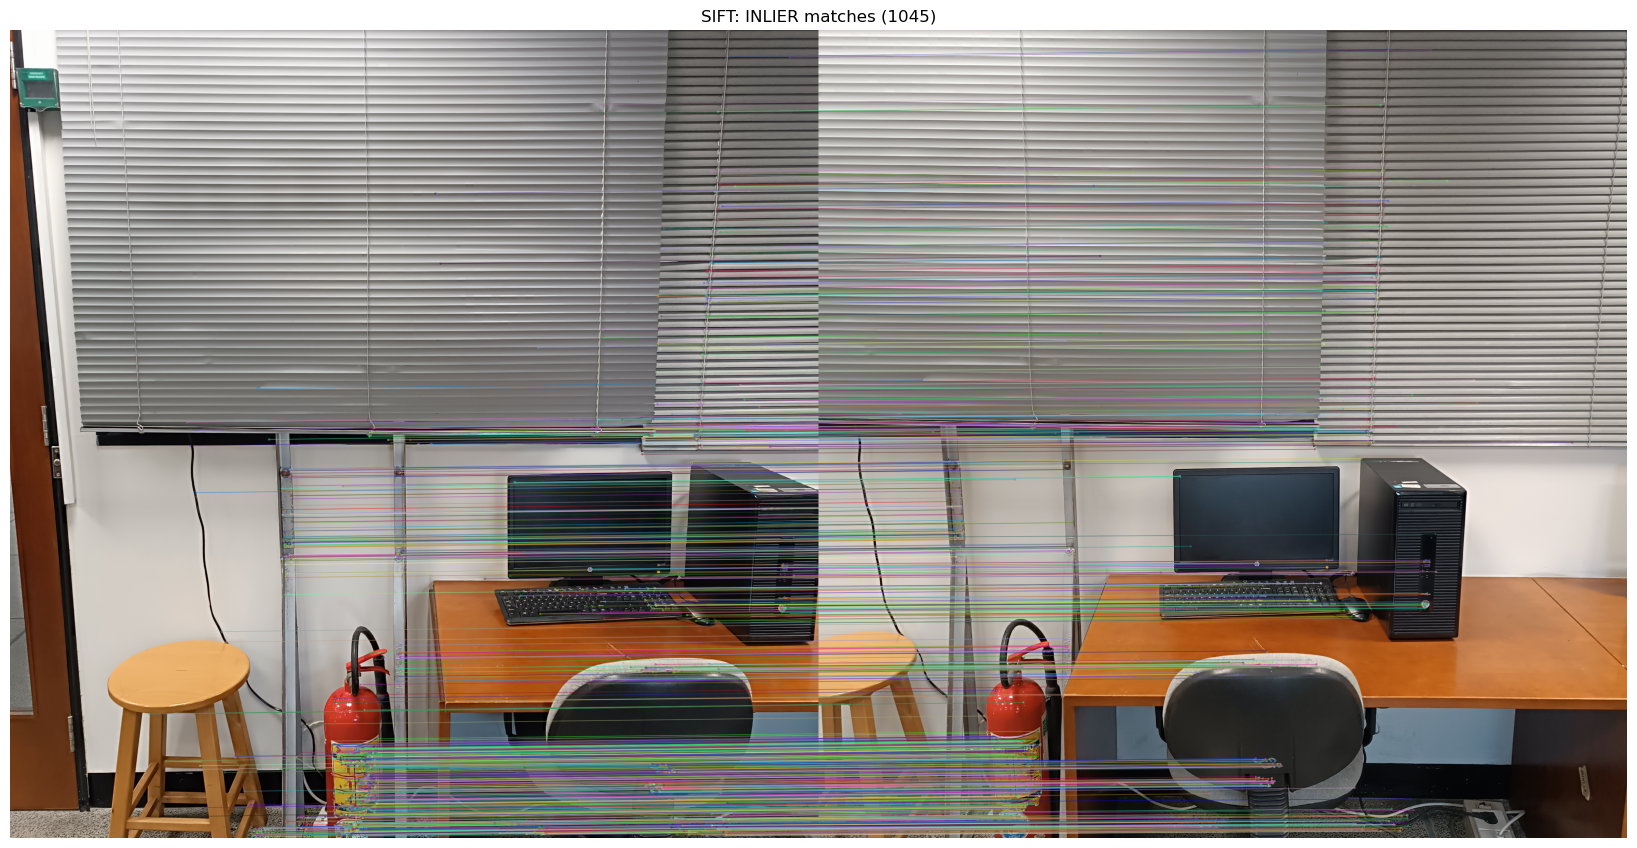

Saved: C:\Users\Omair\Documents\LUMS\Fall-25\EE 513 - CV Fundamentals\Project\Notebooks\Phase2-Final\Arsalan-phase2\two_view_sift_phase1.ply


In [15]:
# phase-1 two-view with explicit recoverPose cross-check
img1 = cv.imread("Images/Test/cv1.jpg", cv.IMREAD_COLOR)
img2 = cv.imread("Images/Test/cv2.jpg", cv.IMREAD_COLOR)
assert img1 is not None and img2 is not None, "Check paths"

target_w = 3000
if img1.shape[1] > target_w:
    s = target_w / img1.shape[1]
    img1 = cv.resize(img1, (target_w, int(img1.shape[0]*s)), interpolation=cv.INTER_AREA)
    img2 = cv.resize(img2, (target_w, int(img2.shape[0]*s)), interpolation=cv.INTER_AREA)

K = build_K_from_image(img1).astype(np.float64)
print("K-matrix:\n", K)

algo = "SIFT" # or "ORB"

# detect and match (with ratio), visualise pre-RANSAC matches
kp1, kp2, good, pts1_all, pts2_all = detect_and_match(img1, img2, algo=algo)
print(f"{algo}: ratio-kept = {len(good)}")
draw_matches_inline(img1, kp1, img2, kp2, good, title=f"{algo}: ratio matches", scale=0.35)

# essential matrix with RANSAC (using K) -> inlier correspondences
E, inl1_E, inl2_E, keep_E = find_E_ransac(pts1_all, pts2_all, K, threshold_px=2.0)
print(f"E-RANSAC inliers = {len(inl1_E)}")
np.set_printoptions(precision=4, suppress=True)
print("Estimated essential matrix E (shape {}):".format(E.shape))
print(E)

# 4) svd + cheirality: enumerate 4 poses, triangulate, and pick the valid one
count, R_svd, t_svd, X_all, mask_cheir = select_pose_by_cheirality(E, K, inl1_E, inl2_E)
print(f"\nCheirality best (points in front of both cams) = {count}")
print("Selected pose (SVD route):")
print("R_svd =\n", R_svd)
print("t_svd^T =", t_svd.ravel())

# using recoverPose
in1_cv = inl1_E.astype(np.float32).reshape(-1,1,2)
in2_cv = inl2_E.astype(np.float32).reshape(-1,1,2)
retval, R_cv, t_cv, mask_cv = cv.recoverPose(E.astype(np.float64), in1_cv, in2_cv, K)

# comparing our implementation with opencv's
t_svd_u = (t_svd / (np.linalg.norm(t_svd) + 1e-12)).reshape(3,1)
t_cv_u  = (t_cv  / (np.linalg.norm(t_cv)  + 1e-12)).reshape(3,1)

cosang = float(np.clip((t_svd_u.T @ t_cv_u).ravel()[0], -1.0, 1.0))
ang_deg = np.degrees(np.arccos(cosang))
ang_deg = min(ang_deg, 180.0 - ang_deg)  # compare up to sign

print("\nOpenCV recoverPose result:")
print("R_cv =\n", R_cv)
print("t_cv^T =", t_cv.ravel())
print("Points in front of both cameras (recoverPose):", int(retval))
print("Inlier count used by recoverPose mask:", int(mask_cv.sum()) if mask_cv is not None else "N/A")

# pose consistency check
fro_R = np.linalg.norm(R_svd - R_cv, ord="fro")
print("\nPose agreement comparison:")
print(f"‣ ||R_svd - R_cv||_F = {fro_R:.4e}")
print(f"‣ angle(t_svd, t_cv) up to sign = {ang_deg:.3f} deg")

# keep the svd + cheirality pose for the rest of our pipeline 
X = X_all[mask_cheir]

# reprojection rmse on the kept inliers
rmse1, rmse2 = reprojection_rmse(K, R_svd, t_svd, inl1_E[mask_cheir], inl2_E[mask_cheir], X)
print(f"\nReproj RMSE (px): view1={rmse1:.2f}, view2={rmse2:.2f}")

# Show inlier matches (pre-cheirality) for the phase-1 deliverable
inlier_matches = [m for m, keep in zip(good, keep_E) if keep]
draw_matches_inline(img1, kp1, img2, kp2, inlier_matches, title=f"{algo}: INLIER matches ({len(inlier_matches)})", scale=0.35)

# save a two-view ply
ply_path = PROJECT_ROOT / f"two_view_{algo.lower()}_phase1.ply"
write_ply(ply_path, X)
print("Saved:", ply_path)


## SIFT with RANSAC (for demonstration) ##

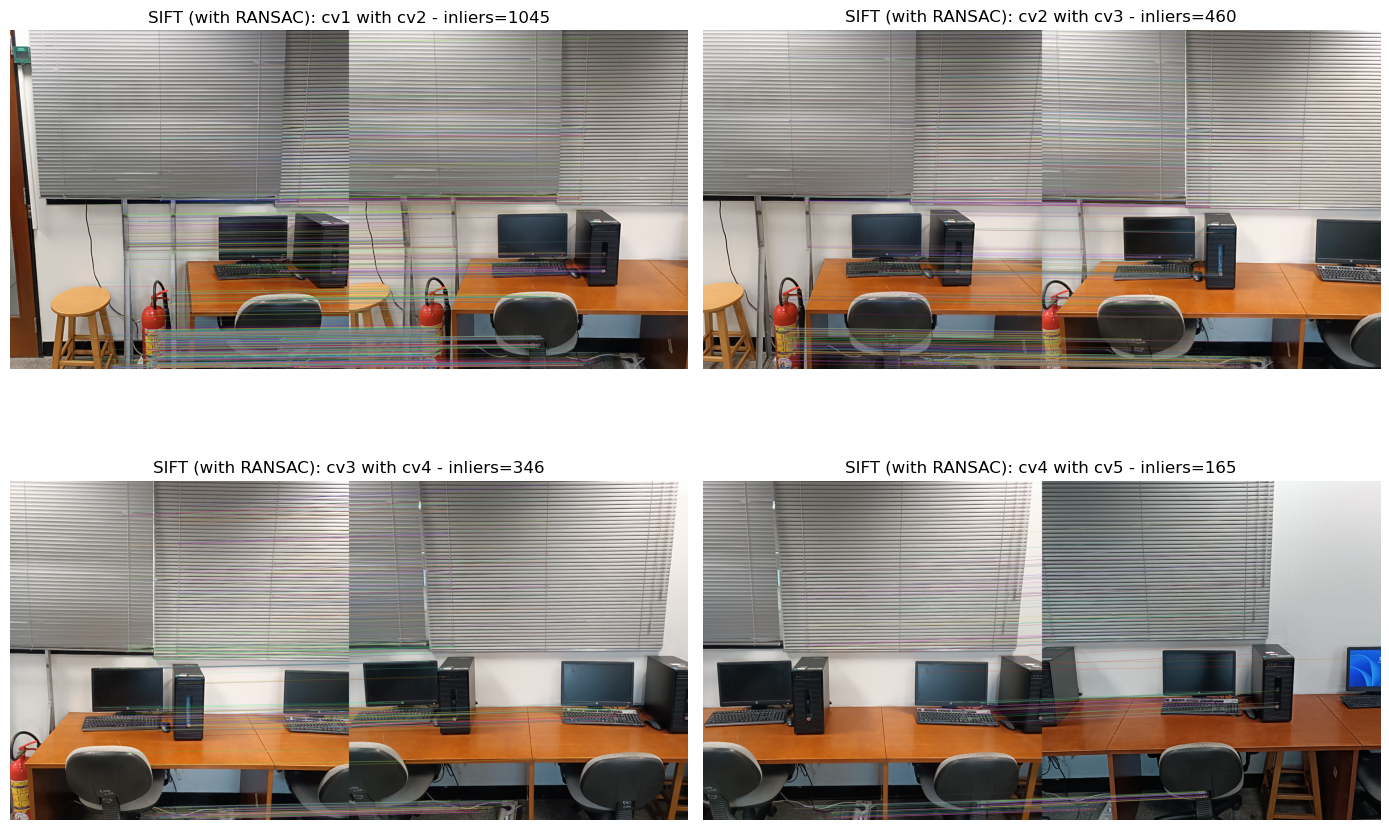

In [16]:
# post-RANSAC inlier matches for 4 consecutive image pairs (1–2, 2–3, 3–4, 4–5)

def inlier_vis_for_pair(pathA, pathB, algo="SIFT", target_w=3000):
    A = cv.imread(pathA, cv.IMREAD_COLOR)
    B = cv.imread(pathB, cv.IMREAD_COLOR)
    assert A is not None and B is not None, f"Missing: {pathA} or {pathB}"

    # resizing this as these are just for displaying the 4 point matches that the TA asked us to do
    # note that for plotting the point cloud, the working has been done in the previous cell!
    if A.shape[1] > target_w:
        s = target_w / A.shape[1]
        A = cv.resize(A, (target_w, int(A.shape[0]*s)), interpolation=cv.INTER_AREA)
        B = cv.resize(B, (target_w, int(B.shape[0]*s)), interpolation=cv.INTER_AREA)

    K_here = build_K_from_image(A)

    # detect + ratio
    kp1, kp2, good, pts1_all, pts2_all = detect_and_match(A, B, algo=algo)
    if len(good) < 8:
        return None, 0, f"Too few matches ({len(good)})"

    # E with RANSAC, keep inliers
    E, inl1_E, inl2_E, keep_E = find_E_ransac(pts1_all, pts2_all, K_here, threshold_px=2.0)
    nin = len(inl1_E)

    # build the inlier-only match list for pretty drawing
    inlier_matches = [m for m, keep in zip(good, keep_E) if keep]
    vis_bgr = cv.drawMatches(A, kp1, B, kp2, inlier_matches, None,
                             flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    vis_rgb = cv.cvtColor(vis_bgr, cv.COLOR_BGR2RGB)
    return vis_rgb, nin, None

pairs = [(1,2), (2,3), (3,4), (4,5)]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for ax, (i,j) in zip(axes, pairs):
    pathA = f"Images/Test/cv{i}.jpg"
    pathB = f"Images/Test/cv{j}.jpg"
    vis, nin, err = inlier_vis_for_pair(pathA, pathB, algo=algo, target_w=3000)
    if err:
        ax.text(0.5, 0.5, err, ha="center", va="center"); ax.axis("off")
    else:
        ax.imshow(vis); ax.set_title(f"{algo} (with RANSAC): cv{i} with cv{j} - inliers={nin}"); ax.axis("off")

plt.tight_layout(); plt.show()


# Reprojection, 3D point cloud generation and Visualization (using Open3D) #

### Note: Open3D GUI only opens in python environment ###

In [17]:
def filter_by_reprojection(K, R, t, pts1, pts2, X, px_thresh=2.0):
    if len(X) == 0:
        return X, pts1, pts2, np.zeros(0, dtype=bool), np.zeros(0)
    P1 = K @ np.hstack([np.eye(3), np.zeros((3,1))])
    P2 = K @ np.hstack([R, t])
    Xh = np.hstack([X, np.ones((len(X),1))]).T  # 4xN

    p1 = (P1 @ Xh); p1 = (p1[:2] / p1[2]).T # Nx2
    p2 = (P2 @ Xh); p2 = (p2[:2] / p2[2]).T # Nx2
    e1 = np.linalg.norm(p1 - pts1, axis=1)
    e2 = np.linalg.norm(p2 - pts2, axis=1)
    err = np.maximum(e1, e2)
    keep = (err <= px_thresh)
    return X[keep], pts1[keep], pts2[keep], keep, err

def filter_by_3d_percentile(X, hi=97):
    if len(X) == 0:
        return X, np.zeros(0, dtype=bool), np.zeros(0)
    med = np.median(X, axis=0)
    d = np.linalg.norm(X - med, axis=1)
    thr = np.percentile(d, hi)
    keep = (d <= thr)
    return X[keep], keep, d

# using the same pose from the svd and cheirality step
R_use, t_use = R_svd, t_svd
pts1_use = inl1_E[mask_cheir].astype(np.float64)
pts2_use = inl2_E[mask_cheir].astype(np.float64)

X_rep, in1_rep, in2_rep, keep_rep, err_rep = filter_by_reprojection(
    K.astype(np.float64), R_use.astype(np.float64), t_use.astype(np.float64),
    pts1_use, pts2_use, X.astype(np.float64), px_thresh=2.0
)
if len(X_rep) < 10:
    X_rep, in1_rep, in2_rep, keep_rep, err_rep = filter_by_reprojection(
        K.astype(np.float64), R_use.astype(np.float64), t_use.astype(np.float64),
        pts1_use, pts2_use, X.astype(np.float64), px_thresh=3.0
    )

# removing some outliers to aid visualisation via open3d
X_vis, keep3d, d3 = filter_by_3d_percentile(X_rep, hi=97)

print(f"Cloud sizes — raw: {len(X)}, reproj<=2/3 px: {len(X_rep)}, after 3D trim: {len(X_vis)}")


Cloud sizes — raw: 1045, reproj<=2/3 px: 1045, after 3D trim: 1013


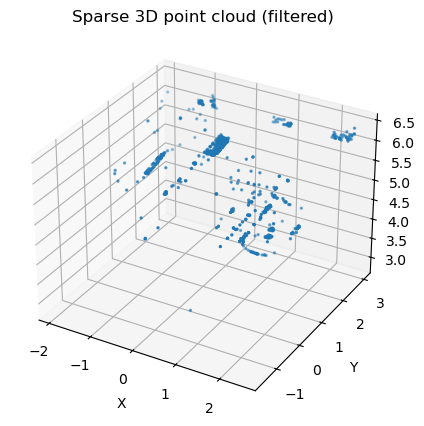

[Open3D INFO] WebRTC GUI backend enabled.


In [18]:
# plotting and visualising point cloud using open3D
# matplotlib inline 3D to display the filtered points
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_vis[:,0], X_vis[:,1], X_vis[:,2], s=2)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.set_title("Sparse 3D point cloud (filtered)")
plt.show()

# interactive viewer using open3D
# the 2 coordinates show the position of my phone's camera when shooting the 2 pictures
try:
    import open3d as o3d
    
    def make_o3d_cloud(X, color=(0.2, 0.6, 1.0)):
        pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(X.astype(np.float64)))
        pcd.paint_uniform_color(color)
        return pcd

    def cam_frame(T=np.eye(4), size=0.2):
        f = o3d.geometry.TriangleMesh.create_coordinate_frame(size=size, origin=[0,0,0])
        f.transform(T)
        return f

    # this is the world orgin (camera 1's position)
    T_cam1 = np.eye(4)

    # camera 2's position # this gives slightly flawed results
    #T_cam2 = np.eye(4)
    #T_cam2[:3,:3] = R
    #T_cam2[:3, 3] = t.flatten()

    # camera 2 pose in world coordinates for open3d (version 2)
    C2 = (-R.T @ t).ravel() # camera center in world
    T_cam2 = np.eye(4)
    T_cam2[:3, :3] = R.T # cam to world rotation
    T_cam2[:3, 3]  = C2 # cam to world translation

    extent = np.percentile(np.linalg.norm(X_vis - np.median(X_vis, axis=0), axis=1), 90)
    axis_size = max(0.05, 0.15 * float(extent))

    pcd  = make_o3d_cloud(X_vis, color=(0.2, 0.6, 1.0))
    axis1 = cam_frame(T_cam1, size=axis_size) # cam-1 at origin
    axis2 = cam_frame(T_cam2, size=axis_size) # cam-2 pose

    # saving the point clouds
    o3d.io.write_point_cloud(str(PROJECT_ROOT / f"two_view_{algo.lower()}_phase1_raw.ply"), 
                             o3d.geometry.PointCloud(o3d.utility.Vector3dVector(X.astype(np.float64))))
    o3d.io.write_point_cloud(str(PROJECT_ROOT / f"two_view_{algo.lower()}_phase1_filtered.ply"),  pcd)

    try:
        o3d.visualization.webrtc_server.enable_webrtc()
        o3d.visualization.draw([pcd, axis1, axis2])
    except Exception:
        o3d.visualization.draw_geometries([pcd, axis1, axis2]) # will open a window
except Exception as e:
    print("Open3D not available; showing only Matplotlib preview.", e)


# Phase 2: Incremental SfM and Refinement #

### Helper Functions and Perspective-n-Point (PnP) algorithm Implementation ###

Bootstrapped: cam2 inliers=1045 | map points=1045
[cam3] pose estimated with 79 PnP inliers.
[cam3] triangulated new points: 561
[cam4] pose estimated with 42 PnP inliers.
[cam4] triangulated new points: 563
[cam5] pose estimated with 7 PnP inliers.
[cam5] triangulated new points: 354
[cam6] pose estimated with 22 PnP inliers.
[cam6] triangulated new points: 594
[cam7] pose estimated with 18 PnP inliers.
[cam7] triangulated new points: 323
[cam8] pose estimated with 36 PnP inliers.
[cam8] triangulated new points: 434
[cam9] pose estimated with 45 PnP inliers.
[cam9] triangulated new points: 443
[cam10] pose estimated with 73 PnP inliers.
[cam10] triangulated new points: 457
[cam11] pose estimated with 50 PnP inliers.
[cam11] triangulated new points: 520
[cam12] pose estimated with 61 PnP inliers.
[cam12] triangulated new points: 476

Sequential SfM done: cams=12 / points=5770


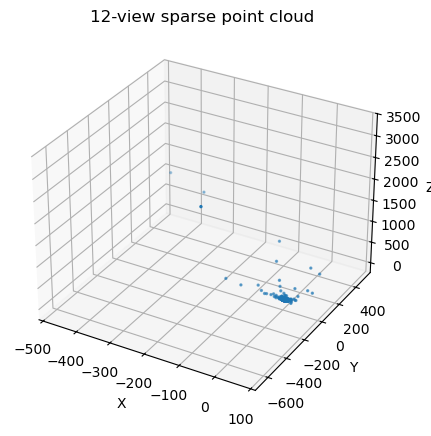

Saved: C:\Users\Omair\Documents\LUMS\Fall-25\EE 513 - CV Fundamentals\Project\Notebooks\Phase2-Final\Arsalan-phase2\sequence_12views_sparse.ply


In [19]:
# sequential sfm over 12 images 
folder = "Images/Test"
indices = list(range(1, 13)) # cv1 ... cv12
algo = "SIFT" # or "ORB"
target_w = 3000                       
min_pnp_pts = 12 # 3D-2D needed for robust pnp
triang_min_parallax_deg = 0.5       

# load & resize the whole sequence consistently
imgs = []
for i in indices:
    im = cv.imread(f"{folder}/cv{i}.jpg", cv.IMREAD_COLOR)
    assert im is not None, f"Missing {folder}/cv{i}.jpg"
    if im.shape[1] > target_w:
        s = target_w / im.shape[1]
        im = cv.resize(im, (target_w, int(im.shape[0]*s)), interpolation=cv.INTER_AREA)
    imgs.append(im)

# intrinsics for the resized images 
K_seq = build_K_from_image(imgs[0])

# detect & describe all frames once
det, norm, ratio = get_detector(algo)
kps  = []
descs = []
for im in imgs:
    g = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    kp, des = det.detectAndCompute(g, None)
    kps.append(kp); descs.append(des)

# helper funciton: match consecutive frames with ratio test
def match_ij(i, j):
    bf = cv.BFMatcher(norm, crossCheck=False)
    knn = bf.knnMatch(descs[i], descs[j], k=2)
    good = [m for m,n in knn if n is not None and m.distance < ratio*n.distance]
    pts_i = np.float32([kps[i][m.queryIdx].pt for m in good])
    pts_j = np.float32([kps[j][m.trainIdx].pt for m in good])
    return good, pts_i, pts_j

# global camera poses (R,t) in world of cam-1 (P1 = [I|0])
cams_seq = {} # i -> (R_i, t_i)
cams_seq[0] = (np.eye(3), np.zeros((3,1))) # cam 1

# point map
points_3d = []
pid_of = [dict() for _ in imgs]

g12, p1, p2 = match_ij(0, 1)
E_12, in1_E, in2_E, keep_E = find_E_ransac(p1, p2, K_seq, threshold_px=2.0)
cnt, R2, t2, X12_all, mask12 = select_pose_by_cheirality(E_12, K_seq, in1_E, in2_E)
cams_seq[1] = (R2, t2)

# keep only cheirality-positive points and record point ids for the matched kps
in1 = in1_E[mask12]; in2 = in2_E[mask12]
X12 = X12_all[mask12]

# build lookup from 2D point coordinates to nearest kp indices
def nearest_kp_index(kplist, pt):
    # brute-force 2D nearest
    pts = np.float32([kp.pt for kp in kplist])
    d = np.linalg.norm(pts - pt, axis=1)
    return int(np.argmin(d))

for pt1, pt2, X in zip(in1, in2, X12):
    i1 = nearest_kp_index(kps[0], pt1)
    i2 = nearest_kp_index(kps[1], pt2)
    pid = len(points_3d)
    points_3d.append(X)
    pid_of[0][i1] = pid
    pid_of[1][i2] = pid

print(f"Bootstrapped: cam2 inliers={len(X12)} | map points={len(points_3d)}")

# sequentially add cameras 3 to 12
for k in range(2, len(imgs)):
    # match (k-1,k)
    good, p_prev, p_cur = match_ij(k-1, k)

    # build 3D-2D for pnp. if kp_prev has a 3D point id, use it
    obj3d = []
    img2d = []
    idx_prev = []
    idx_cur  = []
    for m in good:
        q = m.queryIdx # index in k-1
        t = m.trainIdx # index in k
        if q in pid_of[k-1]:
            pid = pid_of[k-1][q]
            obj3d.append(points_3d[pid])
            img2d.append(kps[k][t].pt)
            idx_prev.append(q); idx_cur.append(t)

    obj3d = np.asarray(obj3d, dtype=np.float64)
    img2d = np.asarray(img2d, dtype=np.float64)

    if len(obj3d) < min_pnp_pts:
        print(f"[cam{k+1}] Not enough 3D-2D for PnP ({len(obj3d)}). Skipping this view.")
        continue

    # pnp (RANSAC) to estimate cam-k pose in world of cam-1
    success, rvec, tvec, inliers = cv.solvePnPRansac(
        objectPoints=obj3d,
        imagePoints=img2d,
        cameraMatrix=K_seq,
        distCoeffs=None,
        iterationsCount=2000,
        reprojectionError=2.0,
        confidence=0.999,
        flags=cv.SOLVEPNP_ITERATIVE
    )
    if not success or inliers is None or len(inliers) < 6:
        print(f"[cam{k+1}] PnP failed/inliers too few.")
        continue
    Rk, _ = cv.Rodrigues(rvec)
    tk    = tvec.reshape(3,1)
    cams_seq[k] = (Rk, tk)
    print(f"[cam{k+1}] pose estimated with {len(inliers)} PnP inliers.")

    # add PnP inlier observations to pid_of[k] so next frames can use them
    for ii in inliers.ravel().tolist():
        q = idx_prev[ii]      # kp index in frame k-1
        t = idx_cur[ii]       # kp index in frame k
        if q in pid_of[k-1]:
            pid_of[k][t] = pid_of[k-1][q]

    # triangulate new points for matches between (k-1, k) that don't have a pid yet
    R_prev, t_prev = cams_seq[k-1]
    new_tri = 0
    for m in good:
        qi, ti = m.queryIdx, m.trainIdx
        if (qi in pid_of[k-1]) or (ti in pid_of[k]):
            continue
        # triangulate this pair (k-1,k)
        pt_prev = np.float64(kps[k-1][qi].pt)
        pt_cur  = np.float64(kps[k][ti].pt)
        P1 = K_seq @ np.hstack([R_prev, t_prev])
        P2 = K_seq @ np.hstack([Rk, tk])
        Xh = cv.triangulatePoints(P1, P2,
                                  pt_prev.reshape(2,1), pt_cur.reshape(2,1))
        X  = (Xh[:3] / Xh[3]).ravel()
        # cheirality check for both cams
        if X[2] <= 0: # depth in cam-1 frame (world = cam1)
            continue
        X_cam_k = Rk @ X.reshape(3,1) + tk
        if X_cam_k[2,0] <= 0:
            continue
        pid = len(points_3d)
        points_3d.append(X)
        pid_of[k-1][qi] = pid
        pid_of[k][ti]   = pid
        new_tri += 1
    print(f"[cam{k+1}] triangulated new points: {new_tri}")

# final arrays
X_seq = np.asarray(points_3d, dtype=np.float64)
print(f"\nSequential SfM done: cams={len(cams_seq)} / points={len(X_seq)}")

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_seq[:,0], X_seq[:,1], X_seq[:,2], s=2)
ax.set_title("12-view sparse point cloud"); ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
plt.show()

# save merged cloud
write_ply(PROJECT_ROOT / "sequence_12views_sparse.ply", X_seq)
print("Saved:", PROJECT_ROOT / "sequence_12views_sparse.ply")


## Reprojection Error Computations of 3D points and triming for visualization ##

In [20]:
# helpers
def per_point_observations(pid_of, kps):
    """pid -> list of (frame_idx, (u,v)). Uses pid_of mapping built in the SfM cell."""
    obs = {}
    for i, mapping in enumerate(pid_of):
        for kp_idx, pid in mapping.items():
            obs.setdefault(pid, []).append((i, kps[i][kp_idx].pt))
    return obs

def reproj_errors_for_point(pid, Xp, obs, cams, K):
    """Return a list of reprojection errors (px) of one 3D point across all its observed frames."""
    errs = []
    if pid not in obs: 
        return errs
    Xh = np.array([Xp[0], Xp[1], Xp[2], 1.0], dtype=np.float64)
    for i, (u, v) in obs[pid]:
        if i not in cams:
            continue
        R, t = cams[i]
        P = K @ np.hstack([R, t])
        p = P @ Xh
        if p[2] <= 1e-8:
            errs.append(1e9)   # behind camera → huge error to force reject
            continue
        uhat, vhat = p[0]/p[2], p[1]/p[2]
        errs.append(np.hypot(uhat - u, vhat - v))
    return errs

# compute per-point median reprojection error (this is just for our report mostly)
obs = per_point_observations(pid_of, kps)
err_med = np.full(len(X_seq), np.inf, dtype=np.float64)
views   = np.zeros(len(X_seq), dtype=np.int32)

for pid in range(len(X_seq)):
    e = reproj_errors_for_point(pid, X_seq[pid], obs, cams_seq, K_seq)
    if len(e) > 0:
        err_med[pid] = float(np.median(e))
        views[pid]   = len(e)

# keep points seen in >= 2 views and with median error <= 2 pixels
rep_mask = (views >= 2) & (err_med <= 2.0)
X_rep = X_seq[rep_mask]
print(f"Reproj filter -> kept {len(X_rep)}/{len(X_seq)} points (>=2 views & median err <= 2 px)")

if len(X_rep) >= 10:
    med = np.median(X_rep, axis=0)
    d = np.linalg.norm(X_rep - med, axis=1)
    hi = np.percentile(d, 97) # tried a few thresholds but 97% was giving decent results
    mask_3d = (d <= hi)
else:
    mask_3d = np.ones(len(X_rep), dtype=bool)

X_seq_filtered = X_rep[mask_3d]
print(f"3D trim → kept {len(X_seq_filtered)} points after robust cutoff")

# save both versions for transparency
write_ply(PROJECT_ROOT / "sequence_12views_sparse_raw.ply", X_seq)
write_ply(PROJECT_ROOT / "sequence_12views_sparse_filtered.ply", X_seq_filtered)
print("Saved raw & filtered PLYs.")

# visualise (Open3D) with all camera frames
try:
    import open3d as o3d

    def cam_frame(T=np.eye(4), size=0.2):
        f = o3d.geometry.TriangleMesh.create_coordinate_frame(size=size, origin=[0,0,0])
        f.transform(T)
        return f

    # axis size from filtered cloud extent
    if len(X_seq_filtered) >= 5:
        extent = np.percentile(np.linalg.norm(X_seq_filtered - np.median(X_seq_filtered, axis=0), axis=1), 90)
        axis_size = max(0.05, 0.15 * float(extent))
    else:
        axis_size = 0.2

    frames = [cam_frame(np.eye(4), size=axis_size)] # cam-1 at origin
    for i in sorted(cams_seq.keys()):
        if i == 0: continue
        R, t = cams_seq[i]
        T = np.eye(4); T[:3,:3] = R; T[:3,3] = t.ravel()
        frames.append(cam_frame(T, size=axis_size))

    pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(X_seq_filtered))
    pcd.paint_uniform_color([0.2, 0.6, 1.0])

    try:
        o3d.visualization.webrtc_server.enable_webrtc()
        o3d.visualization.draw([pcd, *frames])
    except Exception:
        o3d.visualization.draw_geometries([pcd, *frames])
except Exception as e:
    print("Open3D not available:", e)


Reproj filter -> kept 3294/5770 points (>=2 views & median err <= 2 px)
3D trim → kept 3195 points after robust cutoff
Saved raw & filtered PLYs.
[Open3D INFO] WebRTC GUI backend enabled.


In [21]:
# fast bundle adjustment. it prunes weak points, caps the count, and uses a sparse jacobian.
# build observations (cam_idx, pid, u, v)
cam_ids = sorted(cams_seq.keys())
cam_to_idx = {c:i for i,c in enumerate(cam_ids)}
num_cams = len(cam_ids)

obs_cam = []
obs_pid = []
obs_uv  = []
for c in cam_ids:
    mapping = pid_of[c] # kp_index -> pid
    for kp_idx, pid in mapping.items():
        u, v = kps[c][kp_idx].pt
        obs_cam.append(cam_to_idx[c])
        obs_pid.append(pid)
        obs_uv.append([u, v])

obs_cam = np.asarray(obs_cam, dtype=np.int32)
obs_pid = np.asarray(obs_pid, dtype=np.int32)
obs_uv  = np.asarray(obs_uv,  dtype=np.float64)

# keep only points with >= 2 observations
count_by_pid = Counter(obs_pid.tolist())
valid = np.array([count_by_pid[p] >= 2 for p in obs_pid], dtype=bool)
obs_cam, obs_pid, obs_uv = obs_cam[valid], obs_pid[valid], obs_uv[valid]

# Compute quick per-point reprojection error to reduce outliers
def quick_proj_errs(pids, cams_seq, X, K):
    # sample one view per pid (fast) just to rank by error
    sel = defaultdict(list)
    for ic, pid, (u,v) in zip(obs_cam, pids, obs_uv):
        if len(sel[pid]) == 0:
            sel[pid] = [ic, u, v]
    errs = {}
    for pid, (ic,u,v) in sel.items():
        R,t = cams_seq[cam_ids[ic]]
        P = K @ np.hstack([R,t])
        Xh = np.array([*X[pid], 1.0])
        p = P @ Xh
        if p[2] <= 1e-8:
            errs[pid] = 1e9
        else:
            errs[pid] = float(np.hypot(p[0]/p[2]-u, p[1]/p[2]-v))
    return errs

err_rank = quick_proj_errs(obs_pid, cams_seq, X_seq, K_seq)

# keep only points with small quick error (<= 3 px), then cap total to MAX_POINTS
MAX_POINTS = 3000 # note to self: we started testing with 2000! 
good_pids = [pid for pid,e in err_rank.items() if e <= 3.0]

# sort by #views (desc) so we keep well-constrained points
views_per_pid = Counter(obs_pid.tolist())
good_pids.sort(key=lambda p: (-views_per_pid[p], err_rank[p]))

sel_pids = set(good_pids[:MAX_POINTS])
mask_sel = np.array([p in sel_pids for p in obs_pid], dtype=bool)
obs_cam = obs_cam[mask_sel]; obs_pid = obs_pid[mask_sel]; obs_uv = obs_uv[mask_sel]

uniq_pids = sorted(set(obs_pid.tolist()))
pid_old_to_new = {p:i for i,p in enumerate(uniq_pids)}
obs_pid = np.array([pid_old_to_new[p] for p in obs_pid], dtype=np.int32)

X0 = X_seq[uniq_pids].astype(np.float64).copy()
M  = len(uniq_pids)

print(f"BA set: cams={num_cams}, points={M}, observations={len(obs_cam)}")

# parameter packing (cam 0 is fixed)
def pack_params(cams_seq, X):
    cam_params = []
    for i_c, c in enumerate(cam_ids):
        if i_c == 0: # fixed
            continue
        R,t = cams_seq[c]
        rvec,_ = cv.Rodrigues(R)
        cam_params.append(np.hstack([rvec.ravel(), t.ravel()]))
    cam_params = np.concatenate(cam_params) if len(cam_params) else np.zeros(0)
    return cam_params, X.ravel()

def unpack_params(cam_params, X_flat):
    cams = {}
    cams[0] = cams_seq[cam_ids[0]]
    idx = 0
    for i_c, c in enumerate(cam_ids):
        if i_c == 0: continue
        r = cam_params[idx:idx+3]; t = cam_params[idx+3:idx+6]; idx += 6
        R,_ = cv.Rodrigues(r.reshape(3,1))
        cams[i_c] = (R, t.reshape(3,1))
    X = X_flat.reshape(-1,3)
    return cams, X

# sparse jacobian structure
# each 2D residual depends only on (that camera's 6 vars) and (that point's 3 vars)
m = len(obs_cam) * 2
n = 6*(num_cams-1) + 3*M
J = lil_matrix((m, n), dtype=int)

for k,(ic, pid) in enumerate(zip(obs_cam, obs_pid)):
    row_u = 2*k
    row_v = 2*k + 1
    # camera block (if not cam 0)
    if ic != 0:
        j0 = 6*(ic-1)
        J[row_u, j0:j0+6] = 1
        J[row_v, j0:j0+6] = 1
    # point block
    jp = 6*(num_cams-1) + 3*pid
    J[row_u, jp:jp+3] = 1
    J[row_v, jp:jp+3] = 1

J = J.tocsr()

# residual function
K = K_seq.copy()

def residuals(theta):
    cam_params = theta[:6*(num_cams-1)]
    X_flat     = theta[6*(num_cams-1):]
    cams_ba, X = unpack_params(cam_params, X_flat)
    res = np.empty((len(obs_cam)*2,), dtype=np.float64)

    for k,(ic, pid, (u,v)) in enumerate(zip(obs_cam, obs_pid, obs_uv)):
        R,t = cams_ba.get(ic, cams_seq[cam_ids[ic]])
        Xp  = X[pid]
        Xh  = np.array([Xp[0], Xp[1], Xp[2], 1.0], dtype=np.float64)
        P   = K @ np.hstack([R,t])
        p   = P @ Xh
        if p[2] <= 1e-8:
            res[2*k  ] = 1e3
            res[2*k+1] = 1e3
        else:
            uh, vh = p[0]/p[2], p[1]/p[2]
            res[2*k  ] = uh - u
            res[2*k+1] = vh - v
    return res

# solve
cam_params0, X0_flat = pack_params(cams_seq, X0)
theta0 = np.concatenate([cam_params0, X0_flat])

print(f"Optimizing variables={theta0.size} with sparse Jacobian...")
res = least_squares(
    residuals, theta0,
    method="trf",
    jac_sparsity=J, # reducing complexity
    loss="huber", f_scale=2.0, # robust
    max_nfev=120, # tried a bunch of values
    xtol=1e-8, ftol=1e-8, gtol=1e-8,
    verbose=2
)

# calling the functions
cam_params_opt = res.x[:6*(num_cams-1)]
Xopt_flat = res.x[6*(num_cams-1):]
cams_ba, Xopt = unpack_params(cam_params_opt, Xopt_flat)

for i_c, c in enumerate(cam_ids):
    if i_c == 0: continue
    cams_seq[c] = cams_ba[i_c]

X_seq[uniq_pids] = Xopt
print("Fast BA done. cams_seq and X_seq updated.")


BA set: cams=12, points=3000, observations=6377
Optimizing variables=9066 with sparse Jacobian...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6373e+03                                    1.21e+06    
       1              2         1.5509e+03      8.64e+01       8.51e-05       3.05e+05    
       2              3         1.5400e+03      1.09e+01       3.76e-05       2.38e+05    
       3              4         1.5344e+03      5.63e+00       3.07e-05       2.14e+05    
       4              5         1.5301e+03      4.26e+00       2.54e-05       1.61e+05    
       5              6         1.5266e+03      3.44e+00       2.25e-05       1.38e+05    
       6              7         1.5211e+03      5.56e+00       5.96e-05       2.11e+05    
       7              8         1.5174e+03      3.74e+00       2.10e-05       1.41e+05    
       8              9         1.5135e+03      3.81e+00       4.29e-05       2.08e

## Reprojection Error Statistics ##
note that this is mostly for our report and verification

Points with valid reproj data: 5674/5770
Median(err) px: mean(trimmed)=1.51, median=1.10, p90=91.59, p95=237.55


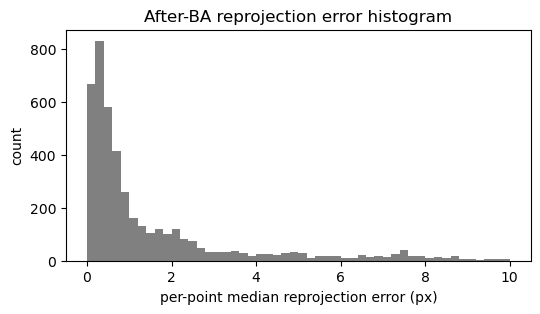

In [22]:
def per_point_obs(pid_of, kps):
    obs = {}
    for i, mapping in enumerate(pid_of):
        for kp_idx, pid in mapping.items():
            obs.setdefault(pid, []).append((i, kps[i][kp_idx].pt))
    return obs

def point_reproj_errs(pid, Xp, obs, cams, K):
    if pid not in obs: 
        return []
    errs = []
    Xh = np.array([Xp[0], Xp[1], Xp[2], 1.0], dtype=np.float64)
    for i,(u,v) in obs[pid]:
        if i not in cams: 
            continue
        R,t = cams[i]
        P = K @ np.hstack([R,t])
        p = P @ Xh
        if p[2] <= 1e-8:
            errs.append(np.nan) # remove outliers
            continue
        uh, vh = p[0]/p[2], p[1]/p[2]
        errs.append(float(np.hypot(uh-u, vh-v)))
    return errs

obs = per_point_obs(pid_of, kps)
err_med = np.full(len(X_seq), np.nan)
views   = np.zeros(len(X_seq), dtype=int)

for pid in range(len(X_seq)):
    e = np.array(point_reproj_errs(pid, X_seq[pid], obs, cams_seq, K_seq), dtype=float)
    if e.size:
        views[pid]   = np.isfinite(e).sum()
        if np.isfinite(e).any():
            err_med[pid] = np.nanmedian(e)

valid = np.isfinite(err_med)
vals  = err_med[valid]
print(f"Points with valid reproj data: {valid.sum()}/{len(X_seq)}")
print(f"Median(err) px: mean(trimmed)={np.mean(vals[vals<10]):.2f}, "
      f"median={np.median(vals):.2f}, p90={np.percentile(vals,90):.2f}, "
      f"p95={np.percentile(vals,95):.2f}")

plt.figure(figsize=(6,3))
plt.hist(vals[np.isfinite(vals)], bins=50, range=(0,10), color="gray")
plt.xlabel("per-point median reprojection error (px)"); plt.ylabel("count")
plt.title("After-BA reprojection error histogram"); plt.show()

## Reprojection Error Summary ##

In [26]:
def summarize(name, errs):
    vals = errs[np.isfinite(errs)]
    within10 = vals[vals < 10]
    print(f"[{name}] N={len(vals)} | median={np.median(vals):.2f}px | "
          f"trimmed-mean(<10px)={np.mean(within10):.2f}px | p90={np.percentile(vals,90):.2f}px")

print("Reprojection error summary (per-point median, across all cams):")
summarize("raw", err_med)

# --- prune: >=2 views & median error <= 2 pixels
mask_rep = (views >= 2) & (np.isfinite(err_med)) & (err_med <= 2.0)
X_rep = X_seq[mask_rep]

# 3d trimming
if len(X_rep) >= 10:
    med = np.median(X_rep, axis=0)
    d = np.linalg.norm(X_rep - med, axis=1)
    hi = np.percentile(d, 97)
    mask_3d = (d <= hi)
else:
    mask_3d = np.ones(len(X_rep), dtype=bool)

X_filtered = X_rep[mask_3d]
print(f"Kept {len(X_filtered)} / {len(X_seq)} points after pruning.")

# save both
write_ply(PROJECT_ROOT / "sequence_12views_sparse_raw.ply",      X_seq)
write_ply(PROJECT_ROOT / "sequence_12views_sparse_filtered.ply", X_filtered)
print("Saved PLYs (raw & filtered).")

# clean Open3D visualisation with camera frames
try:
    import open3d as o3d
    def cam_frame(T=np.eye(4), size=0.2):
        f = o3d.geometry.TriangleMesh.create_coordinate_frame(size=size, origin=[0,0,0])
        f.transform(T); return f

    if len(X_filtered) >= 5:
        extent = np.percentile(np.linalg.norm(X_filtered - np.median(X_filtered, axis=0), axis=1), 90)
        axis_size = max(0.05, 0.15*float(extent))
    else:
        axis_size = 0.2

    frames = [cam_frame(np.eye(4), size=axis_size)]
    for i in sorted(cams_seq.keys()):
        if i == 0: continue
        R,t = cams_seq[i]
        T = np.eye(4); T[:3,:3] = R; T[:3,3] = t.ravel()
        frames.append(cam_frame(T, size=axis_size))

    pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(X_filtered))
    pcd.paint_uniform_color([0.2, 0.6, 1.0])

    try:
        o3d.visualization.webrtc_server.enable_webrtc()
        o3d.visualization.draw([pcd, *frames])
    except Exception:
        o3d.visualization.draw_geometries([pcd, *frames])
except Exception as e:
    print("Open3D not available:", e)


Reprojection error summary (per-point median, across all cams):
[raw] N=5674 | median=1.10px | trimmed-mean(<10px)=1.51px | p90=91.59px
Kept 3265 / 5770 points after pruning.
Saved PLYs (raw & filtered).
[Open3D INFO] WebRTC GUI backend enabled.
